# import thư viện

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-bright')

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
import scipy
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


C:\Users\Admin\AppData\Local\Temp\ipykernel_16724\4143896982.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-bright')


# Phân tích chuỗi thời gian công ty

## Tải file

In [165]:
df_raw = pd.read_csv('Data.csv')

df_raw = df_raw.set_index('Time')

df_raw #Dữ liệu sau khi tính tổng competitor theo quý

,Competitor_luong,Competitor_giatri,Company_cri1,Company_cri2
Time,,,,
Q1-2020,5403820.0,3549378.366,NaN,NaN
Q2-2020,11458146.0,8224063.940,NaN,NaN
Q3-2020,18438880.0,7190059.010,NaN,NaN
Q4-2020,10013404.0,6146164.031,NaN,NaN
Q1-2021,4864172.0,2660088.820,735.0,68.0
Q2-2021,10889213.0,6350758.451,330.0,31.0
Q3-2021,4774831.0,3683154.873,560.0,58.0
Q4-2021,9768208.0,7189822.000,750.0,77.0
Q1-2022,6012674.0,4103657.100,730.0,75.0


In [166]:
 round(df_raw.describe(), 2)

,Competitor_luong,Competitor_giatri,Company_cri1,Company_cri2
count,15.00,15.00,12.00,12.00
mean,8509461.53,4801043.75,580.00,58.75
std,3745675.85,1907481.92,152.06,15.55
min,3838228.00,2420021.38,330.00,31.00
25%,5708247.00,3447357.61,450.00,46.00
50%,7652448.00,4103657.10,580.00,60.00
75%,10451308.50,6248461.24,731.25,69.75
max,18438880.00,8224063.94,800.00,82.00


## Xử lý dữ liệu

### Trực quan hóa dữ liệu

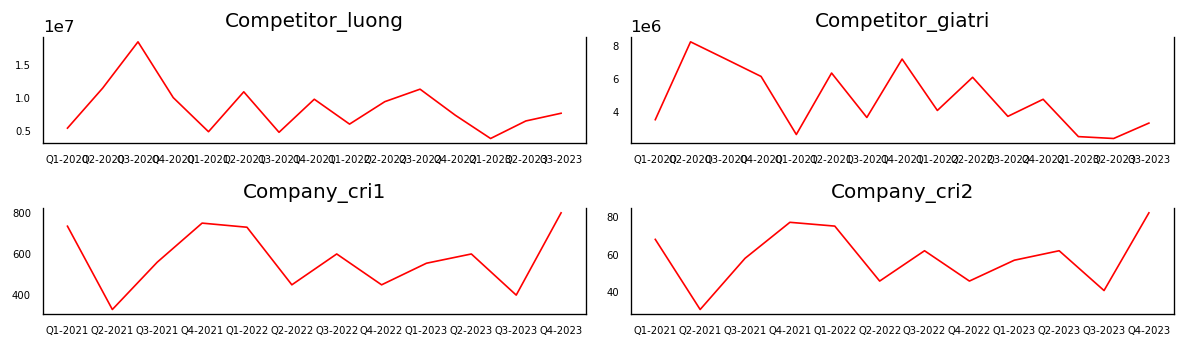

In [167]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,3))

for i, ax in enumerate(axes.flatten()):
    data = df_raw[df_raw.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    #Make charts more readable
    ax.set_title(df_raw.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Time lagged cross correlation 

In [168]:
df_remove_null = df_raw.dropna(subset=['Competitor_luong','Company_cri1','Company_cri2'])

df_remove_null

,Competitor_luong,Competitor_giatri,Company_cri1,Company_cri2
Time,,,,
Q1-2021,4864172.0,2660088.820,735.0,68.0
Q2-2021,10889213.0,6350758.451,330.0,31.0
Q3-2021,4774831.0,3683154.873,560.0,58.0
Q4-2021,9768208.0,7189822.000,750.0,77.0
Q1-2022,6012674.0,4103657.100,730.0,75.0
Q2-2022,9402112.0,6094928.260,450.0,46.0
Q3-2022,11288509.0,3749908.000,600.0,62.0
Q4-2022,7350389.0,4775025.000,450.0,46.0
Q1-2023,3838228.0,2533290.140,555.0,57.0


In [169]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

#### Corr(Company_cri1,Company_cri2)

D:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
D:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


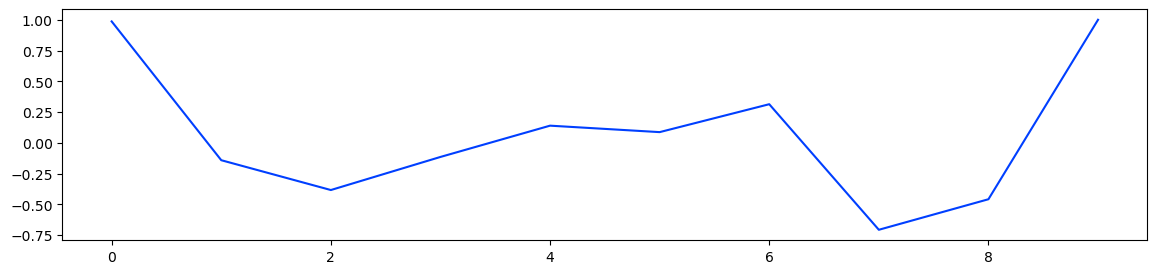

In [170]:
rs = [crosscorr(df_remove_null['Company_cri1'], df_remove_null['Company_cri2'], lag) for lag in range(len(df_remove_null['Company_cri1']))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)

#### Corr(Company_cri2,Company_cri1)

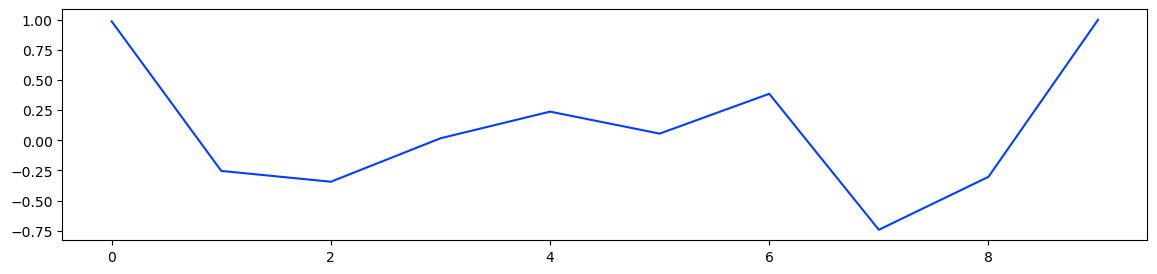

In [171]:
rs = [crosscorr(df_remove_null['Company_cri2'], df_remove_null['Company_cri1'], lag) for lag in range(len(df_remove_null['Company_cri1']))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)

#### Corr(Company_cri1,Competitor_luong)

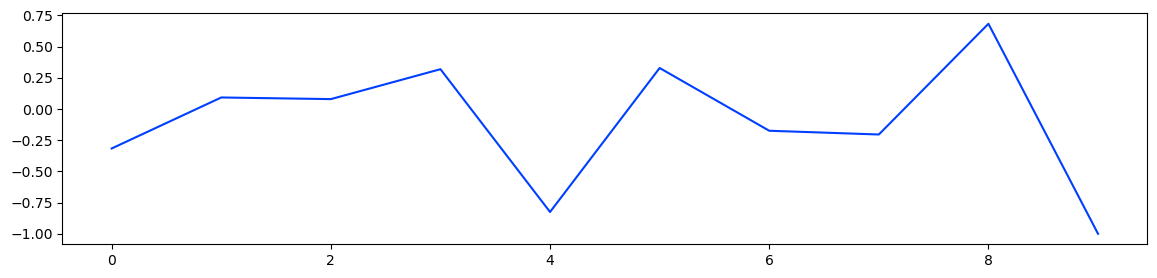

In [172]:
rs = [crosscorr(df_remove_null['Company_cri1'], df_remove_null['Competitor_luong'], lag) for lag in range(len(df_remove_null['Company_cri1']))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)

#### Corr(Company_cri2,Competitor_luong)

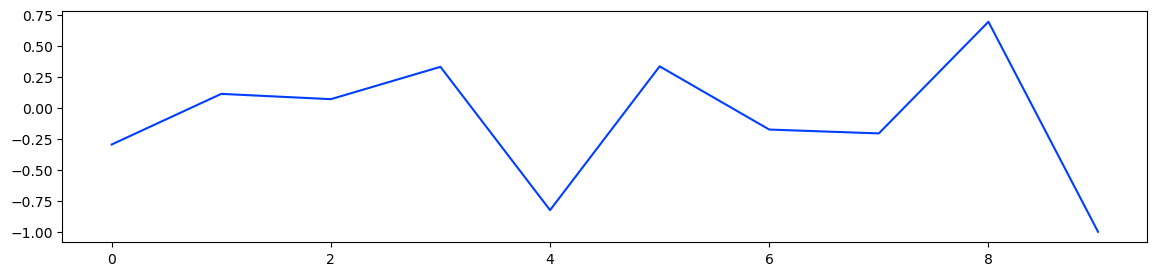

In [173]:
rs = [crosscorr(df_remove_null['Company_cri2'], df_remove_null['Competitor_luong'], lag) for lag in range(len(df_remove_null['Company_cri1']))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)

#### Corr(Company_cri1,Company_giatri)

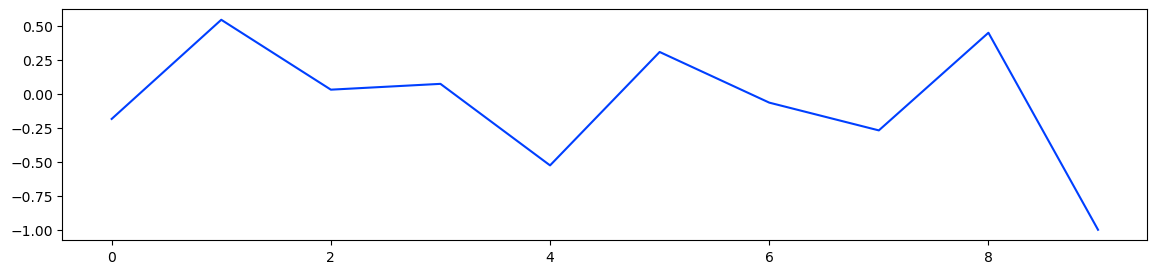

In [174]:
rs = [crosscorr(df_remove_null['Company_cri1'], df_remove_null['Competitor_giatri'], lag) for lag in range(len(df_remove_null['Company_cri1']))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)

#### Corr(Company_cri2,Competitor_giatri)

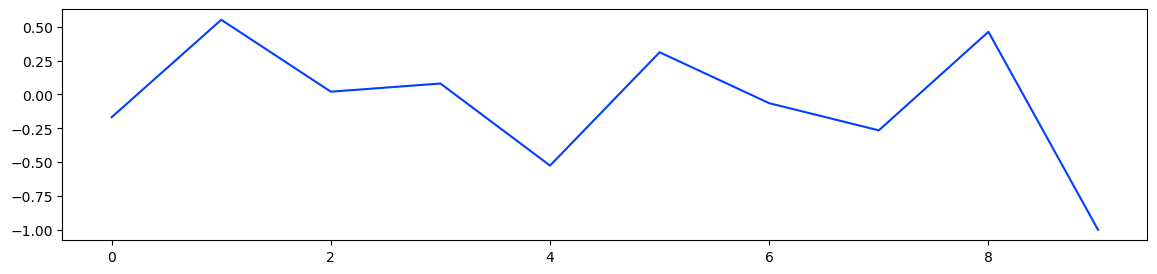

In [175]:
rs = [crosscorr(df_remove_null['Company_cri2'],df_remove_null['Competitor_giatri'], lag) for lag in range(len(df_remove_null['Company_cri1']))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)

Nhiền vào biểu đồ cross-correlation có thể thấy: company_cri1 và company_cri2 có mối tương quan rất mạnh tại lag = 0. Company_cri1, Company_cri2 và Competitor_luong cũng có mối tương quan mạnh (khoảng 0.70) tại lag = 8. Tuy nhiên bộ dữ liệu đang xét khá bé nên ta bỏ qua không xét đến chuỗi Competitor_luong nữa. Vậy company_cri1 và company_cri2 có thể được coi là hai biến của chuỗi thời gian cần xét.

### ACF plot

#### Xét chuỗi thời gian gồm hai biến Company_cri1 và Company_cri2

In [176]:
df = df_raw.drop(columns='Competitor_luong')
df = df.drop(columns='Competitor_giatri')
df = df.dropna()

df

,Company_cri1,Company_cri2
Time,,
Q1-2021,735.0,68.0
Q2-2021,330.0,31.0
Q3-2021,560.0,58.0
Q4-2021,750.0,77.0
Q1-2022,730.0,75.0
Q2-2022,450.0,46.0
Q3-2022,600.0,62.0
Q4-2022,450.0,46.0
Q1-2023,555.0,57.0


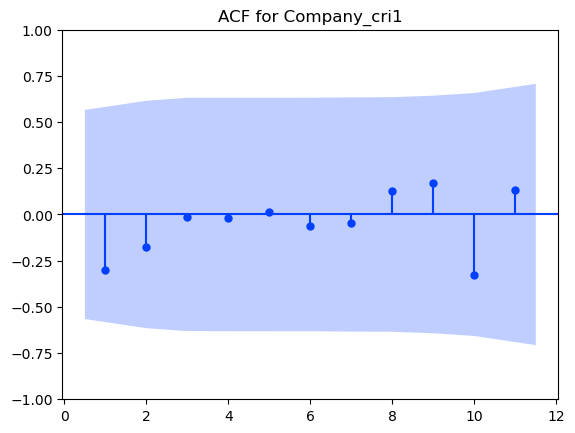

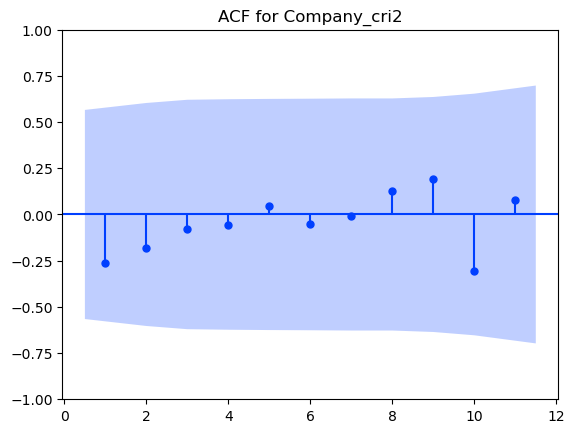

In [177]:
for i in df:
    sgt.plot_acf(df[i], zero=False)
    plt.title('ACF for %s' % i) 
    plt.show()

### PACF plot

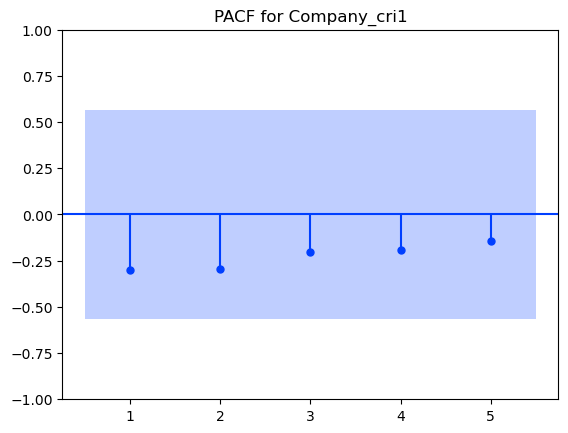

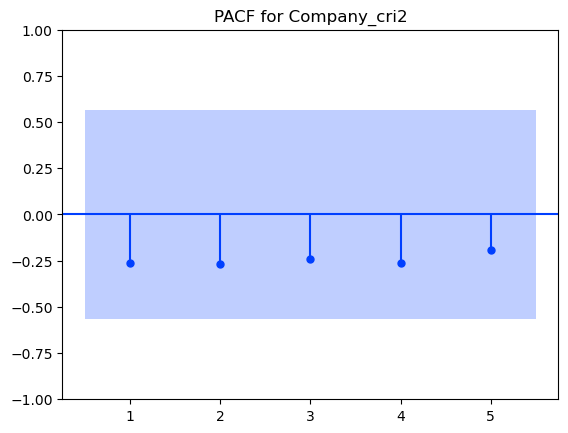

In [178]:
for i in df:
    sgt.plot_pacf(df[i], lags=5, zero=False)
    plt.title('PACF for %s' % i) 
    plt.show()

## ADF test

In [179]:
def adf_test(timeseries, name):
    dftest = sts.adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print('\033[1m{:10s}\033[0m'.format(name))
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=4).mean()
    rolstd = timeseries.rolling(window=4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Company_cri1
Test Statistic         -3.559083
p-value                 0.006593
Lags Used               4.000000
Observations Used       7.000000
Critical Value (1%)    -4.938690
Critical Value (5%)    -3.477583
Critical Value (10%)   -2.843868
dtype: float64


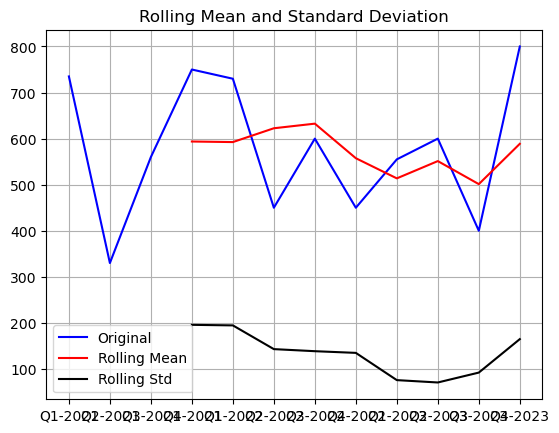

Company_cri2
Test Statistic         -3.622412
p-value                 0.005347
Lags Used               4.000000
Observations Used       7.000000
Critical Value (1%)    -4.938690
Critical Value (5%)    -3.477583
Critical Value (10%)   -2.843868
dtype: float64


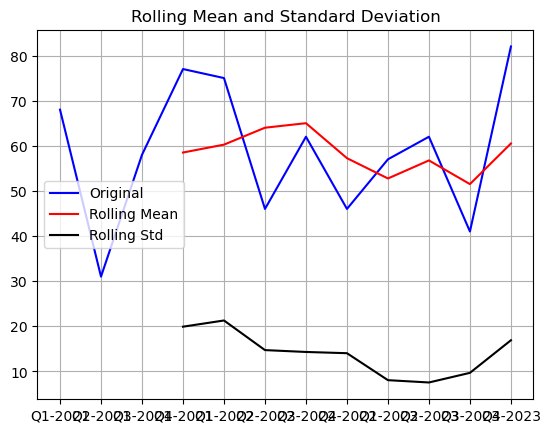

In [180]:
for i in df:
    adf_test(df[i], i)

Vì Test Statistic < Critical Value nên có thể bác bỏ giả thiết về tính non-stationary của chuỗi. Chuỗi thời gian có tính dừng và có thể sử dụng ngay mô hình VARMA mà không cần phải biến đổi. 

## Dataset Split

In [181]:
size = int(len(df) * 0.80)
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [182]:
print(len(df_train))
print(len(df_test))

9
3


In [183]:
df_train

,Company_cri1,Company_cri2
Time,,
Q1-2021,735.0,68.0
Q2-2021,330.0,31.0
Q3-2021,560.0,58.0
Q4-2021,750.0,77.0
Q1-2022,730.0,75.0
Q2-2022,450.0,46.0
Q3-2022,600.0,62.0
Q4-2022,450.0,46.0
Q1-2023,555.0,57.0


In [184]:
df_test

,Company_cri1,Company_cri2
Time,,
Q2-2023,600.0,62.0
Q3-2023,400.0,41.0
Q4-2023,800.0,82.0


## VAR model

### Lag order selection

In [185]:
 #Initiate VAR model
var_model = VAR(endog=df_train)
res_var = var_model.select_order(maxlags=1, trend='ct') #chọn max lag = 1 vì dữ liệu rất nhỏ
res_var.summary()

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,9.804,9.844,1.851e+04,9.536
1,8.206*,8.286*,4463.*,7.671*


Rõ ràng lag = 1 cho kết quả tốt nhất

### Fit the model

In [186]:
var_model_fit = var_model.fit(maxlags=1, ic='aic')
var_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 22, Jan, 2024
Time:                     20:35:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.59585
Nobs:                     8.00000    HQIC:                   8.13442
Log likelihood:          -50.8481    FPE:                    5503.76
AIC:                      8.53627    Det(Omega_mle):         2911.08
--------------------------------------------------------------------
Results for equation Company_cri1
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 661.059128       188.312692            3.510           0.000
L1.Company_cri1        -3.322923         1.865582           -1.781           0.075
L1.Company_cri2        31.184856        18.34

### Check for serial correlation of residuals

In [187]:
dw_check_var = durbin_watson(var_model_fit.resid)

for col, val in zip(df_train.columns, dw_check_var):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
Company_cri1 --> 1.67
----------------------------
Durbin-Watson statistic for:
Company_cri2 --> 1.64
----------------------------


Vì giá trị Durbin-Watson statistic khá gần 2 nên residual ít tương quan nên có thể chuyển sang bước tiếp theo.

### Making predictions

In [188]:
 #Get the lag order
lag_order = var_model_fit.k_ar
print(lag_order)

1


In [189]:
#Input data for forecasting
pred_input = df_train.values[-lag_order:]
pred_input

array([[555.,  57.]])

In [190]:
#Forecasting
var_pred = var_model_fit.forecast(y=pred_input, steps=len(df_test))

df_var_pred = pd.DataFrame(var_pred, index = df_test.index, columns = df_train.columns)

df_var_pred

,Company_cri1,Company_cri2
Time,,
Q2-2023,594.373542,61.171349
Q3-2023,593.621194,61.010226
Q4-2023,591.096588,60.728239


### Evaluate the predictions

Sử dụng MAPE (i.e., |actual-forecast| / |actual| * 100). Taking 1-MAPE, we obtain the accuracy of our prediction.

In [191]:
var_mape = metrics.mean_absolute_percentage_error(df_test, df_var_pred)

var_model_accuracy = 1 - var_mape
print("The accuracy of the VAR out-of-sample prediction is:")
print("----------------------------------------------------")
print(round(var_model_accuracy, 3))

The accuracy of the VAR out-of-sample prediction is:
----------------------------------------------------
0.747


Độ chính xác của mô hình ở mức chấp nhận được

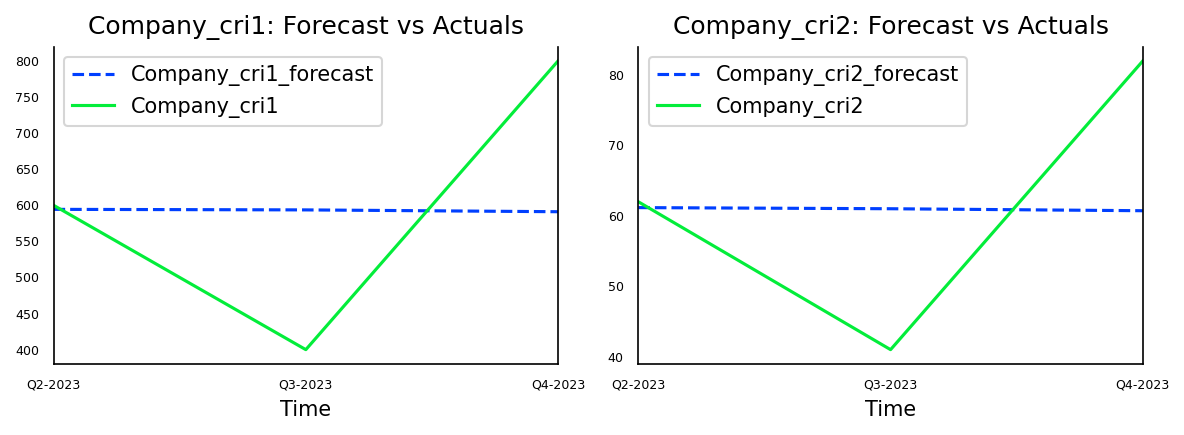

In [192]:
df_var_pred = df_var_pred.rename(columns={"Company_cri1": "Company_cri1_forecast", "Company_cri2": "Company_cri2_forecast"})

fig, axes = plt.subplots(nrows=int(len(df_test.columns)/2), ncols=2, dpi=150, figsize=(8,3))
for i, (col,ax) in enumerate(zip(df_test.columns, axes.flatten())):
    df_var_pred[col+ '_forecast'].plot(legend=True, ax=ax, linestyle='--').autoscale(axis='x',tight=True)
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## VARMA model

###  Finding otpimal hyper-parameters

In [193]:
param_grid = {'p': [1,2], 'q':[1,2]}
pg = list(ParameterGrid(param_grid))

In [194]:
df_fitted_VARMA = pd.DataFrame(columns=['p', 'q', 'AIC'])

for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    model = VARMAX(df_train, order=(p,q)).fit()
    aic = model.aic
    
    #l = len(df_fitted_VARMA) + 1
    #df_fitted_VARMA.loc[l] = [p,q,aic]
    df_fitted_VARMA = df_fitted_VARMA.append({'p': p, 'q': q, 'AIC':aic}, ignore_index=True)
    

    

D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16724\2004717729.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fitted_VARMA = df_fitted_VARMA.append({'p': p, 'q': q, 'AIC':aic}, ignore_index=True)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,

In [195]:
df_fitted_VARMA.sort_values(by=['AIC'])

,p,q,AIC
3,2.0,2.0,160.957611
0,1.0,1.0,168.721179
2,2.0,1.0,169.965996
1,1.0,2.0,175.455231


Có thể thấy AIC của (p,q)=(2,2) là bé nhất. Do đó chọn mô hình VARMA(2,2)

### Fit the model

In [196]:
varma_model = VARMAX(endog=df_train, order=(2,2), trend='t')
varma_model_fit = varma_model.fit()

varma_model_fit.summary()

D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'


Dep. Variable:,"['Company_cri1', 'Company_cri2']",No. Observations:,9
Model:,"VARMA(2,2)",Log Likelihood,-63.818
,+ intercept,AIC,169.637
Date:,"Mon, 22 Jan 2024",BIC,173.779
Time:,20:35:43,HQIC,160.699
Sample:,0,,
,- 9,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.88, 0.36",Jarque-Bera (JB):,"0.12, 2.67"
Prob(Q):,"0.35, 0.55",Prob(JB):,"0.94, 0.26"
Heteroskedasticity (H):,"0.83, 0.02",Skew:,"-0.02, -1.24"


### Check for serial correlation of residuals

In [197]:
dw_check_varma = durbin_watson(varma_model_fit.resid)

for col, val in zip(df_train.columns, dw_check_varma):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
Company_cri1 --> 1.57
----------------------------
Durbin-Watson statistic for:
Company_cri2 --> 1.69
----------------------------


Vì giá trị Durbin-Watson statistic khá gần 2 nên residual ít tương quan nên có thể chuyển sang bước tiếp theo.

###  Making predictions

In [198]:
varma_pred = varma_model_fit.forecast(steps=len(df_test))
df_varma_pred = pd.DataFrame(varma_pred.values, 
                             index=df_test.index, 
                             columns=df_train.columns)

df_varma_pred

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


,Company_cri1,Company_cri2
Time,,
Q2-2023,737.835542,76.926507
Q3-2023,974.027828,99.361571
Q4-2023,962.004491,98.075965


###  Evaluate the predictions

In [199]:
varma_mape = metrics.mean_absolute_percentage_error(df_test, df_varma_pred)
varma_model_accuracy = 1 - varma_mape

print("The accuracy of the VARMA out-of-sample prediction is:")
print("----------------------------------------------------")
print(round(varma_model_accuracy, 3))

The accuracy of the VARMA out-of-sample prediction is:
----------------------------------------------------
0.379


Mô hình này không chính xác. Không dùng để dự báo.

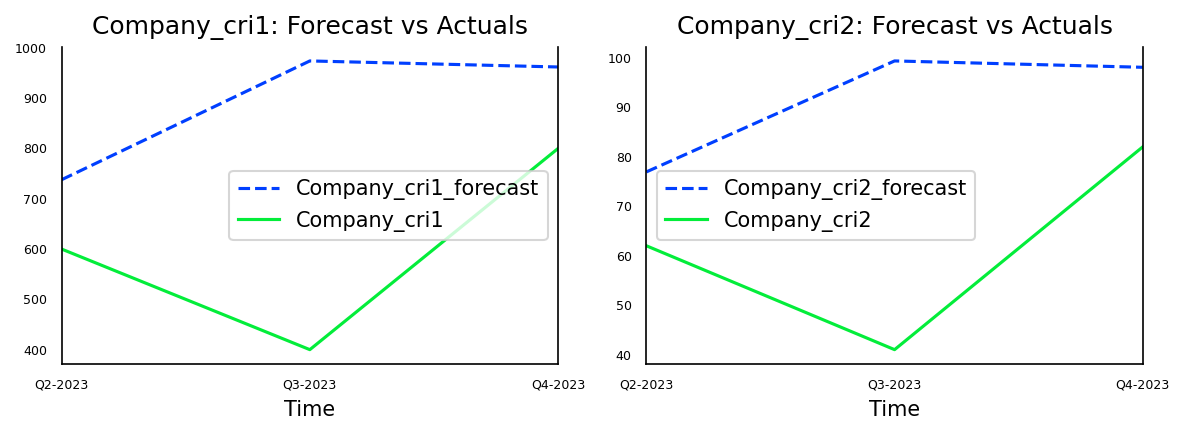

In [200]:
df_varma_pred = df_varma_pred.rename(columns={"Company_cri1": "Company_cri1_forecast", "Company_cri2": "Company_cri2_forecast"})

fig, axes = plt.subplots(nrows=int(len(df_test.columns)/2), ncols=2, dpi=150, figsize=(8,3))
for i, (col,ax) in enumerate(zip(df_test.columns, axes.flatten())):
    df_varma_pred[col+ '_forecast'].plot(legend=True, ax=ax, linestyle='--').autoscale(axis='x',tight=True)
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [201]:
print("VAR model accuracy is: " + str(var_model_accuracy))
print("-----------------------------------------------------")
print("VARMA model accuracy is: " + str(varma_model_accuracy))

VAR model accuracy is: 0.7474348292203922
-----------------------------------------------------
VARMA model accuracy is: 0.37874125214412313


# Forecasting sử dụng VAR(1)

Thực hiện lại các bước như trên nhưng thay vì fit model trên tập train, ta fit model trên cả tập dữ liệu.

In [202]:
df

,Company_cri1,Company_cri2
Time,,
Q1-2021,735.0,68.0
Q2-2021,330.0,31.0
Q3-2021,560.0,58.0
Q4-2021,750.0,77.0
Q1-2022,730.0,75.0
Q2-2022,450.0,46.0
Q3-2022,600.0,62.0
Q4-2022,450.0,46.0
Q1-2023,555.0,57.0


In [203]:
#initial VAR model
var_fc_model = VAR(endog=df)

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [204]:
#fit the model
var_model_fc_fit = var_fc_model.fit(maxlags=1, ic='aic')
var_model_fc_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 22, Jan, 2024
Time:                     20:35:44
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.86988
Nobs:                     11.0000    HQIC:                   8.51604
Log likelihood:          -72.8073    FPE:                    5890.95
AIC:                      8.65285    Det(Omega_mle):         3636.76
--------------------------------------------------------------------
Results for equation Company_cri1
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 769.633226       178.938393            4.301           0.000
L1.Company_cri1        -3.146762         1.899349           -1.657           0.098
L1.Company_cri2        27.516999        18.74

In [205]:
#Checking for auto-correlation of residuals
dw_check_var_fc = durbin_watson(var_model_fc_fit.resid)

for col, val in zip(df.columns, dw_check_var_fc):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
Company_cri1 --> 1.97
----------------------------
Durbin-Watson statistic for:
Company_cri2 --> 1.96
----------------------------


Durbin-Watson static gần 2, chấp nhận được. Chuyển sang bước tiếp theo.

In [206]:
#Get the lag order
lag_order_fc = var_model_fc_fit.k_ar
print(lag_order_fc)

1


In [207]:
#Input data for forecasting
fc_input = df.values[-lag_order_fc:]
fc_input

array([[800.,  82.]])

## Forcasting trước 1 Quý

In [208]:
fc_window = ['Q1-2024']

In [209]:
len(fc_window)

1

In [210]:
#Making forecasts
var_fc = var_model_fc_fit.forecast(y=fc_input, steps=len(fc_window))

df_var_fc = pd.DataFrame(var_fc, index = fc_window, columns = df.columns)

df_var_fc

,Company_cri1,Company_cri2
Q1-2024,508.617292,51.619665


#### Plotting

In [211]:
#copy dataframe
df1 = df.copy()

#append the forecasts into dataframe for plotting
var_fc_plot = df1.append(df_var_fc)

var_fc_plot

C:\Users\Admin\AppData\Local\Temp\ipykernel_16724\366823576.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  var_fc_plot = df1.append(df_var_fc)


,Company_cri1,Company_cri2
Q1-2021,735.000000,68.000000
Q2-2021,330.000000,31.000000
Q3-2021,560.000000,58.000000
Q4-2021,750.000000,77.000000
Q1-2022,730.000000,75.000000
Q2-2022,450.000000,46.000000
Q3-2022,600.000000,62.000000
Q4-2022,450.000000,46.000000
Q1-2023,555.000000,57.000000
Q2-2023,600.000000,62.000000


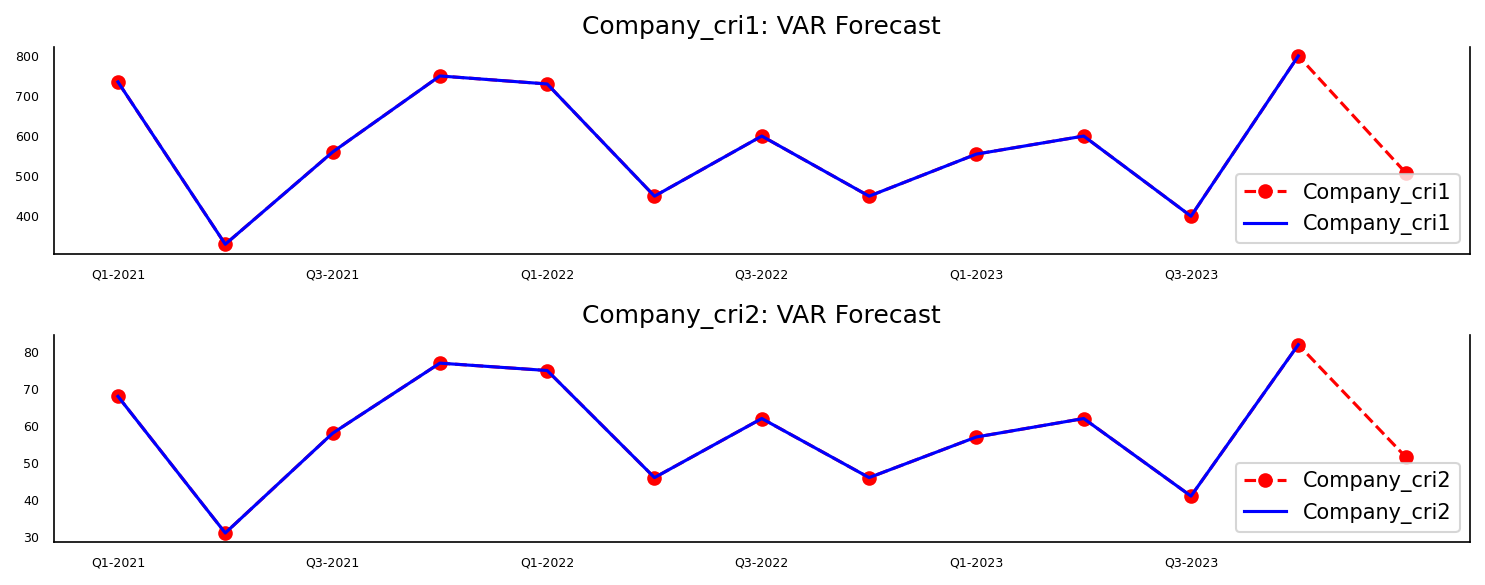

In [212]:
#Plotting our VAR forecasts
fig, axes = plt.subplots(nrows=int(len(var_fc_plot.columns)), ncols=1, dpi=150, figsize=(10,4))
for i, (col,ax) in enumerate(zip(var_fc_plot.columns, axes.flatten())):
    var_fc_plot[col].iloc[0:].plot(legend=True, ax=ax, marker='o', color='r', linestyle='--')
    var_fc_plot[col].iloc[:-1].plot(legend=True, ax=ax, color='b')
    ax.set_title(col + ": VAR Forecast")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Forcasting trước 2 Quý

In [213]:
fc_window = ['Q1-2024', 'Q2-2024']

In [214]:
len(fc_window)

2

In [215]:
#Making forecasts
var_fc = var_model_fc_fit.forecast(y=fc_input, steps=len(fc_window))

df_var_fc = pd.DataFrame(var_fc, index = fc_window, columns = df.columns)

df_var_fc

,Company_cri1,Company_cri2
Q1-2024,508.617292,51.619665
Q2-2024,589.553781,60.545469


#### Plotting

In [216]:
#copy dataframe
df1 = df.copy()

#append the forecasts into dataframe for plotting
var_fc_plot = df1.append(df_var_fc)

var_fc_plot

C:\Users\Admin\AppData\Local\Temp\ipykernel_16724\366823576.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  var_fc_plot = df1.append(df_var_fc)


,Company_cri1,Company_cri2
Q1-2021,735.000000,68.000000
Q2-2021,330.000000,31.000000
Q3-2021,560.000000,58.000000
Q4-2021,750.000000,77.000000
Q1-2022,730.000000,75.000000
Q2-2022,450.000000,46.000000
Q3-2022,600.000000,62.000000
Q4-2022,450.000000,46.000000
Q1-2023,555.000000,57.000000
Q2-2023,600.000000,62.000000


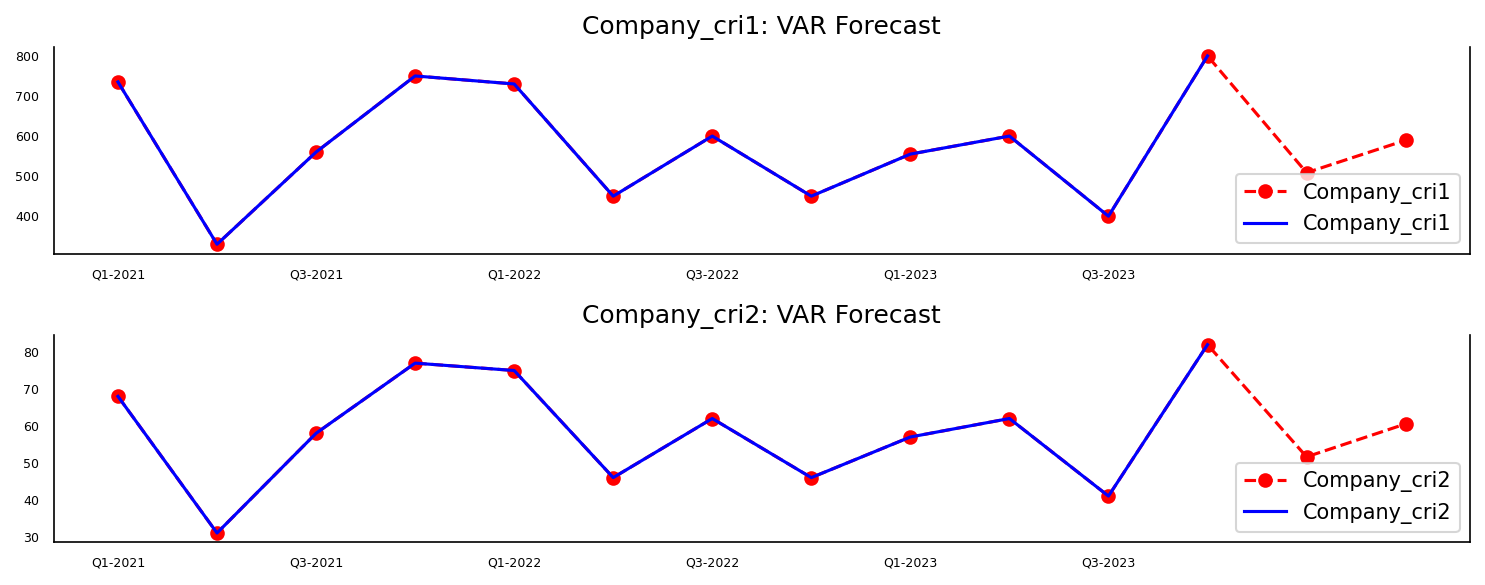

In [217]:
#Plotting our VAR forecasts
fig, axes = plt.subplots(nrows=int(len(var_fc_plot.columns)), ncols=1, dpi=150, figsize=(10,4))
for i, (col,ax) in enumerate(zip(var_fc_plot.columns, axes.flatten())):
    var_fc_plot[col].iloc[0:].plot(legend=True, ax=ax, marker='o', color='r', linestyle='--')
    var_fc_plot[col].iloc[:-2].plot(legend=True, ax=ax, color='b')
    ax.set_title(col + ": VAR Forecast")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Forcasting trước 3 Quý

In [218]:
fc_window = ['Q1-2024', 'Q2-2024', 'Q3-2024']

In [219]:
len(fc_window)

3

In [220]:
#Making forecasts
var_fc = var_model_fc_fit.forecast(y=fc_input, steps=len(fc_window))

df_var_fc = pd.DataFrame(var_fc, index = fc_window, columns = df.columns)

df_var_fc

,Company_cri1,Company_cri2
Q1-2024,508.617292,51.619665
Q2-2024,589.553781,60.545469
Q3-2024,580.477208,59.585688


#### Plotting

In [221]:
#copy dataframe
df1 = df.copy()

#append the forecasts into dataframe for plotting
var_fc_plot = df1.append(df_var_fc)

var_fc_plot

C:\Users\Admin\AppData\Local\Temp\ipykernel_16724\366823576.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  var_fc_plot = df1.append(df_var_fc)


,Company_cri1,Company_cri2
Q1-2021,735.000000,68.000000
Q2-2021,330.000000,31.000000
Q3-2021,560.000000,58.000000
Q4-2021,750.000000,77.000000
Q1-2022,730.000000,75.000000
Q2-2022,450.000000,46.000000
Q3-2022,600.000000,62.000000
Q4-2022,450.000000,46.000000
Q1-2023,555.000000,57.000000
Q2-2023,600.000000,62.000000


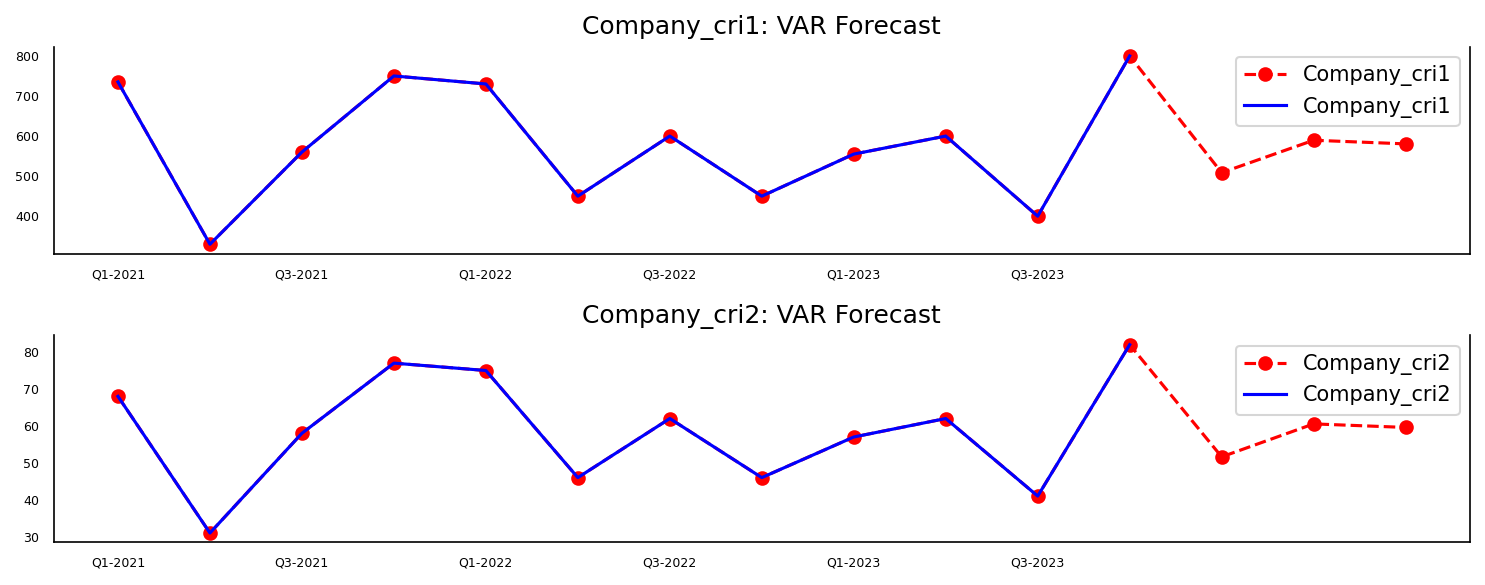

In [222]:
#Plotting our VAR forecasts
fig, axes = plt.subplots(nrows=int(len(var_fc_plot.columns)), ncols=1, dpi=150, figsize=(10,4))
for i, (col,ax) in enumerate(zip(var_fc_plot.columns, axes.flatten())):
    var_fc_plot[col].iloc[0:].plot(legend=True, ax=ax, marker='o', color='r', linestyle='--')
    var_fc_plot[col].iloc[:-3].plot(legend=True, ax=ax, color='b')
    ax.set_title(col + ": VAR Forecast")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Forcasting trước 4 Quý

In [223]:
fc_window = ['Q1-2024', 'Q2-2024', 'Q3-2024', 'Q4-2024']

In [224]:
len(fc_window)

4

In [225]:
#Making forecasts
var_fc = var_model_fc_fit.forecast(y=fc_input, steps=len(fc_window))

df_var_fc = pd.DataFrame(var_fc, index = fc_window, columns = df.columns)

df_var_fc

,Company_cri1,Company_cri2
Q1-2024,508.617292,51.619665
Q2-2024,589.553781,60.545469
Q3-2024,580.477208,59.585688
Q4-2024,582.628738,59.821826


#### Plotting

In [226]:
#copy dataframe
df1 = df.copy()

#append the forecasts into dataframe for plotting
var_fc_plot = df1.append(df_var_fc)

var_fc_plot

C:\Users\Admin\AppData\Local\Temp\ipykernel_16724\366823576.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  var_fc_plot = df1.append(df_var_fc)


,Company_cri1,Company_cri2
Q1-2021,735.000000,68.000000
Q2-2021,330.000000,31.000000
Q3-2021,560.000000,58.000000
Q4-2021,750.000000,77.000000
Q1-2022,730.000000,75.000000
Q2-2022,450.000000,46.000000
Q3-2022,600.000000,62.000000
Q4-2022,450.000000,46.000000
Q1-2023,555.000000,57.000000
Q2-2023,600.000000,62.000000


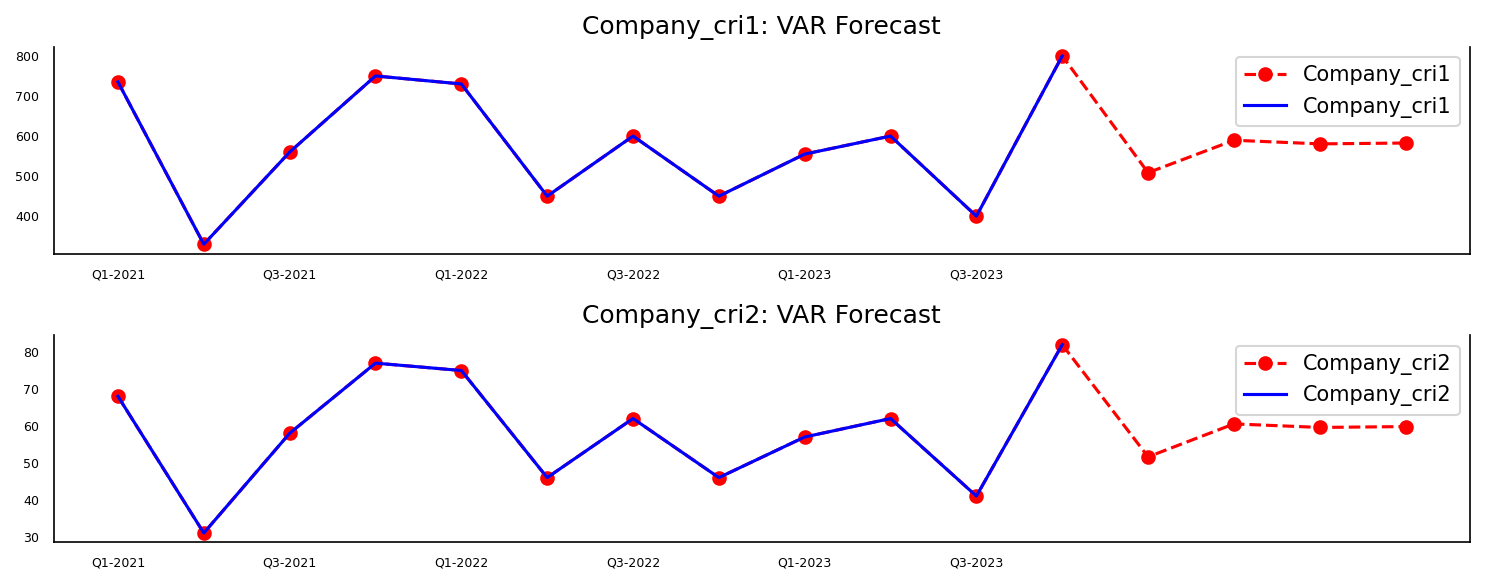

In [227]:
#Plotting our VAR forecasts
fig, axes = plt.subplots(nrows=int(len(var_fc_plot.columns)), ncols=1, dpi=150, figsize=(10,4))
for i, (col,ax) in enumerate(zip(var_fc_plot.columns, axes.flatten())):
    var_fc_plot[col].iloc[0:].plot(legend=True, ax=ax, marker='o', color='r', linestyle='--')
    var_fc_plot[col].iloc[:-4].plot(legend=True, ax=ax, color='b')
    ax.set_title(col + ": VAR Forecast")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();